# Figure 1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.colors as mcolors

sys.path.append('./')
sys.path.append('../..') 
sys.path.append('../Fig3')
from consensus_variables import * 
from plot_f1 import *
from load_data_f1 import *
from plot_f3 import *

In [3]:
# TODO: think how to add this in the repo
sys.path.append("/data/bbg/projects/bladder_ts/scripts/regressions/")
from utils_regressions import univar_mixedeffects_linear_regression

In [4]:
# paths
data_dir = "../../data"
figures_dir = "figs/"
siprofiler_dir = os.path.join(data_dir, "sigprofiler")

# files
mutrate_file = os.path.join(deepcsa_run_dir, "mutrate/all_mutrates.tsv")
signatures_file = os.path.join(siprofiler_dir, "SBS96_De-Novo_Signatures.txt")
signatures_activ_file = os.path.join(siprofiler_dir, "SBS96_De-Novo_Activities_refit.txt")

## Fig1B

In [5]:
gene_order = ["KMT2D","EP300","ARID1A","CREBBP","NOTCH2","RB1","RBM10","TP53",
            "CDKN1A","FOXQ1", "KDM6A", "STAG2", "FGFR3",]

cancer_cohort_df = pd.read_table(f"{intogen_path}/cohorts.tsv")

In [6]:
dna_prot_df = pd.read_table(f"{deepcsa_run_dir}/dna2proteinmapping/exons_splice_sites.mapping.tsv",
                        sep="\t",
                        header = 0)
dna_prot_df

,CHR,DNA_POS,GENE,CONTEXT,PROT_POS,REVERSE_STRAND,EXON,COVERED
0,chr1,26696404,ARID1A,NaN,1.0,1.0,0.0,0
1,chr1,26696405,ARID1A,NaN,1.0,1.0,0.0,0
2,chr1,26696406,ARID1A,NaN,1.0,1.0,0.0,0
3,chr1,26696407,ARID1A,NaN,2.0,1.0,0.0,0
4,chr1,26696408,ARID1A,NaN,2.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...
140207,chr19,6751207,TRIP10,NaN,601.0,1.0,14.0,0
140208,chr19,6751208,TRIP10,NaN,601.0,1.0,14.0,0
140209,chr19,6751209,TRIP10,NaN,602.0,1.0,14.0,0
140210,chr19,6751210,TRIP10,NaN,602.0,1.0,14.0,0


In [7]:
# Normal bladder SNVs and indels
print("Processing normal...")
normal_maf_df = get_normal_maf(somatic_maf_file,
                            lst_genes = gene_order)

# Bladder cancer SNVs and indels
print("Processing cancer...")
cancer_type = ["BLCA", "BLADDER"]
blca_cancer_df = get_cancer_maf_all(cancer_cohort_df[cancer_cohort_df["CANCER_TYPE"].isin(cancer_type)], 
                                    intogen_muts_path,
                                    lst_genes = normal_maf_df["Gene"].unique())

# Exclude sites that are not in the normal consensus panel
print("Excluding mutations...")
normal_df = normal_maf_df[normal_maf_df["DNA_POS"].isin(dna_prot_df[dna_prot_df["COVERED"] == 1]["DNA_POS"])]
print(f"\tafter removing for masked (normal): {len(normal_df)}")
blca_cancer_df = blca_cancer_df[blca_cancer_df["DNA_pos"].isin(dna_prot_df[dna_prot_df["COVERED"] == 1]["DNA_POS"])]
print(f"\tafter removing for masked (tumor): {len(blca_cancer_df)}")

# Remove indels
normal_df = normal_df[normal_df["Consequence"] != "indel"].reset_index(drop=True)
print(f"\tafter removing for indels (normal): {len(normal_df)}")

blca_cancer_df = blca_cancer_df[blca_cancer_df["Consequence"] != "indel"].reset_index(drop=True)
print(f"\tafter removing for indels (tumor): {len(blca_cancer_df)}")

Processing normal...


/home/fcalvet/projects/bladder_paper/normal_bladder_paper/main/Fig1/load_data_f1.py:244: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  maf_df = pd.read_table(path_maf)


Total number of somatic mutations in the consensus panel: 64278
	Mutations in selected genes: 61201
	SNVs and indels: 60692
Processing cancer...
Excluding mutations...
	after removing for masked (normal): 51236
	after removing for masked (tumor): 2166
	after removing for indels (normal): 32913
	after removing for indels (tumor): 1744


In [8]:
# number of cancer samples
cancer_cohort_df.loc[cancer_cohort_df["CANCER_TYPE"].isin(cancer_type)]["SAMPLES"].sum()

np.int64(892)

In [9]:
# Get total count of SNVs
normal_df_size = normal_df.groupby("Gene").size().reset_index().rename(columns={0 : "SNVs"})
normal_df_size["Type"] = "Normal"
blca_cancer_df = blca_cancer_df.groupby("Gene").size().reset_index().rename(columns={0 : "SNVs"})
blca_cancer_df["Type"] = "Cancer"
size_df = pd.concat((normal_df_size, blca_cancer_df)).reset_index(drop=True)
size_df

,Gene,SNVs,Type
0,ARID1A,3589,Normal
1,CDKN1A,492,Normal
2,CREBBP,2416,Normal
3,EP300,2894,Normal
4,FGFR3,229,Normal
5,FOXQ1,672,Normal
6,KDM6A,2942,Normal
7,KMT2D,11204,Normal
8,NOTCH2,2106,Normal
9,RB1,374,Normal


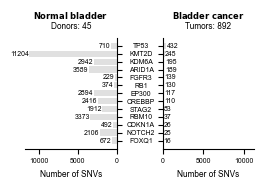

In [10]:
plot_mut_count_comparison(size_df,
                          barcolor = "#E0E0E0",
                          figsize = (2.955, 1.442),
                          filename = os.path.join(figures_dir, "fig1b.pdf"),
                          save = True)

## Fig1C

In [11]:
# load data
cohort_df = load_cohort_data(clinvars_file, somatic_maf_file, mutrate_file)
cohort_df

/home/fcalvet/projects/bladder_paper/normal_bladder_paper/main/Fig1/load_data_f1.py:129: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  muts_df = pd.read_csv(muts_file, sep = "\t")


Total number of mutations 64278
Types of variants included: ['SNV' 'DELETION' 'INSERTION' 'MNV']
	MNV max length: 3
Number of mutations:
	Range: 54 - 1785
	Median: 774.0
Mutation rate:
	Overall median: 1.27
	Overall mean: 1.28
	Overall range: 0.23 - 2.66
	Overall 95% interval: 0.33 - 2.47
	PA median: 1.95
	PA mean: 1.9
	PA range: 0.19 - 3.95
	PA 95% interval: 0.33 - 3.66


,CLEAN_SAMPLE_ID,SAMPLE_ID,SUBJECT_ID,BANK_ID,AGE,SEX,BMI,SMOKING_STATUS,HISTORY_OF_SMOKING,CURRENT_SMOKER,...,CDKN1A_depth,KMT2C_depth,TP53_depth,RB1_depth,FGFR3_depth,PIK3CA_depth,TERTpromoter_depth,total_depth,N_MUTS,MUTRATE_MB
54,36_TR,P19_0036_BTR_01,P19_0036,A20-24,23,M,30.0,current,yes,yes,...,2815.072222,1056.649212,1399.589348,1101.556662,1676.714029,1068.086806,1351.011299,1340.180173,54,0.379595
0,01_DO,P19_0001_BDO_01,P19_0001,A133,24,M,30.1,never,no,no,...,6262.712963,7333.893499,5549.427470,5669.664422,3126.193345,6644.104167,337.807910,4692.917969,167,0.268849
1,01_TR,P19_0001_BTR_01,P19_0001,A133,24,M,30.1,never,no,no,...,7210.483333,7638.135789,6367.466713,5440.150512,3755.018885,6841.708333,490.768362,5105.737962,331,0.510736
36,24_DO,P19_0024_BDO_01,P19_0024,A182,24,M,36.6,never,no,no,...,7782.194444,8305.247393,7267.061668,7276.348755,4774.803058,7982.743056,931.581921,5868.572273,347,0.407569
37,24_TR,P19_0024_BTR_01,P19_0024,A182,24,M,36.6,never,no,no,...,5990.131481,5973.582205,7590.923616,5523.409956,7890.919065,6069.531250,2146.152542,5214.974723,414,0.564920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,29_TR,P19_0029_BTR_01,P19_0029,A188,82,F,32.3,former,yes,no,...,6503.105556,4659.077657,6600.417659,3679.244510,7669.875000,4025.826389,993.209040,4990.763963,1391,2.203324
61,42_DO,P19_0042_BDO_01,P19_0042,20-51,86,M,36.5,former,yes,no,...,27872.485185,5078.097848,6027.944639,5723.397950,16315.818345,5003.013889,996.548023,7899.841569,1633,2.494631
62,42_TR,P19_0042_BTR_01,P19_0042,20-51,86,M,36.5,former,yes,no,...,10415.800000,4119.468826,4499.334268,4348.459444,7069.313849,4619.986111,461.005650,4406.632288,1086,2.470532
28,18_DO,P19_0018_BDO_01,P19_0018,A171,87,M,21.0,former,yes,no,...,5756.661111,6790.777901,5789.284513,5226.209663,3102.107914,6334.031250,1368.723164,4697.318796,697,1.102968


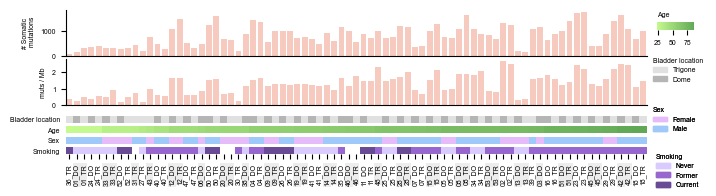

In [12]:
plot_config = {"figsize": (7.5, 1.878),
            "nrows": 7,
            "rows_ordered": ["N_MUTS", "MUTRATE_MB", 
                        "white_space", "is_dome",
                        "AGE", "is_male", 
                        "smoking_status"
                        ],
            "legend_fontsize": plots_general_config["legend_fontsize"],
            "legend_fontweight": "regular",
            "xylabels_fontsize": plots_general_config["xylabel_fontsize"],
            "xyticks_fontsize": plots_general_config["xyticks_fontsize"],
            "legend_order": ["is_dome","is_male", 
                                "smoking_status",
                                "AGE", ],
            "ylabels_pad": {"is_dome": 40, "AGE": 13,
                            "is_male": 13,
                            "smoking_status": 24,
                            },
            "legend_loc": {"is_dome": [1, 0.1],
                            "AGE": [1.017, 8, 1.3, 12],
                            "is_male": [1, 0.1],
                            "smoking_status": [1.1, -10]},
            "legend_title_loc": {"AGE": -25},
            "height_ratios": [4, 4, 0.3, 0.6, 0.6, 0.6, 0.6],
            "ncols_legend": 1
            }
fig1c = cohort_descrp_plot(data_df = cohort_df, plot_config = plot_config,
                        save_file = os.path.join(figures_dir, "fig1c.pdf"))

## Fig1D

In [13]:
signatures_dict = {"SBS96A": "SBS-APOBEC",
                 "SBS96B": "SBS-aging",
                 "SBS96C": "SBS-chemo"}

In [14]:
sigprofiler_df = pd.read_csv(signatures_file, sep = "\t", index_col = 0)
sigprofiler_df

,SBS96A,SBS96B,SBS96C
MutationType,,,
A[C>A]A,0.005363,0.011960,0.052032
A[C>A]C,0.010950,0.009123,0.035504
A[C>A]G,0.004078,0.003188,0.004005
A[C>A]T,0.002578,0.005268,0.031588
A[C>G]A,0.009997,0.004341,0.015314
...,...,...,...
T[T>C]T,0.008482,0.019828,0.014412
T[T>G]A,0.007080,0.007522,0.002670
T[T>G]C,0.001921,0.005070,0.001096


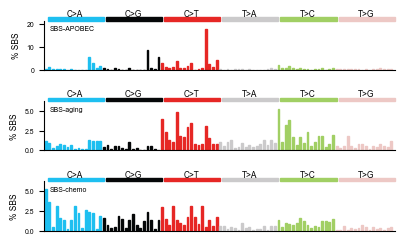

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(4.130, 2.559))
axs = axs.flatten()

# loop through artifacts 
for i, signature in enumerate(signatures_dict.keys()):
    title = signatures_dict[signature]
    plot_signature(sigprofiler_df[[signature]], axs[i], add_contexts=False, text = title,
                ttype = "Percentage")

plt.tight_layout()  
plt.savefig("figs/fig1d.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

## Fig1E

In [16]:
signatures_activ_df = pd.read_csv(signatures_activ_file, sep = "\t", index_col = 0)
clinvars_df = pd.read_csv(clinvars_file, sep = "\t").set_index("SAMPLE_ID")
signatures_activ_df = signatures_activ_df.merge(clinvars_df, right_index = True, left_index = True, how = "inner")
signatures_activ_df

,SBS96A,SBS96B,SBS96C,SUBJECT_ID,BANK_ID,AGE,SEX,BMI,SMOKING_STATUS,HISTORY_OF_SMOKING,...,NOTCH2_depth,FOXQ1_depth,CDKN1A_depth,KMT2C_depth,TP53_depth,RB1_depth,FGFR3_depth,PIK3CA_depth,TERTpromoter_depth,total_depth
P19_0001_BDO_01,26,44,17,P19_0001,A133,24,M,30.1,never,no,...,6010.652090,1896.860909,6262.712963,7333.893499,5549.427470,5669.664422,3126.193345,6644.104167,337.807910,4692.917969
P19_0001_BTR_01,164,30,0,P19_0001,A133,24,M,30.1,never,no,...,6541.577498,2180.124545,7210.483333,7638.135789,6367.466713,5440.150512,3755.018885,6841.708333,490.768362,5105.737962
P19_0002_BDO_01,138,330,481,P19_0002,A135,73,F,27.8,former,yes,...,3795.115970,3929.377273,6685.933333,4337.512758,4897.518570,4504.394436,4819.200540,4912.277778,581.960452,4218.769783
P19_0002_BTR_01,168,245,573,P19_0002,A135,73,F,27.8,former,yes,...,4282.152090,1168.876364,3601.098148,4845.481917,4015.498949,3887.624012,2180.981115,5067.017361,357.197740,3653.830900
P19_0003_BDO_01,325,360,82,P19_0003,A136,75,F,25.2,former,yes,...,5651.285774,2248.772727,4749.966667,7298.584202,6222.145060,5088.027526,2749.334532,6570.277778,1152.158192,5325.770255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P19_0051_BTR_01,281,519,99,P19_0051,NaN,79,M,35.0,former,yes,...,9103.178799,3423.169091,6183.216667,11250.679166,8946.863350,8309.846559,4375.084532,10197.385417,2199.564972,7265.051577
P19_0052_BDO_01,39,91,37,P19_0052,NaN,31,F,44.5,current,yes,...,8950.867700,6724.989091,9597.907407,10454.000666,10035.801682,8557.754319,6531.122302,9640.461806,5426.531073,9069.061127
P19_0052_BTR_01,56,88,58,P19_0052,NaN,31,F,44.5,current,yes,...,4868.489067,4098.137273,4993.168519,5390.901930,5905.169587,4274.387116,4220.028777,4882.638889,2633.853107,4992.780493
P19_0053_BDO_01,206,351,35,P19_0053,NaN,72,M,19.5,former,yes,...,9015.418904,3214.100000,5951.287037,11580.210783,8484.175193,8225.657394,3842.708633,10380.493056,2003.457627,7172.570262


MODEL formula (univariable): SBS96B ~ AGE - 1
MODEL formula (univariable): SBS96C ~ had_prior_chemotherapy + 1


/tmp/ipykernel_2951690/936171782.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(signatures_activ_df, x=clinvar, palette=clinvar2color[clinvar],
/tmp/ipykernel_2951690/936171782.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(signatures_activ_df, x=clinvar, palette=clinvar2color[clinvar],


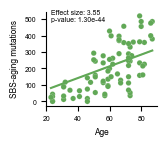

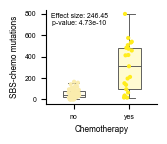

In [17]:
signatures2plot = {"SBS96B": "AGE",
                "SBS96C": "had_prior_chemotherapy"}
for signature in signatures2plot:
    clinvar = signatures2plot[signature]
    signatures_activ_clinvar_df = signatures_activ_df[[signature, clinvar, "SUBJECT_ID"]]
    coeffs_df, lowi_df, highi_df, corr_pvals_df, intercepts_df = univar_mixedeffects_linear_regression(signatures_activ_clinvar_df, [signature],
                                                                                                    [clinvar],
                                                                                                    "SUBJECT_ID",
                                                                                                    correct_pvals = False)
    coeff = coeffs_df[clinvar].values[0]
    pval = corr_pvals_df[clinvar].values[0]
    intercept = intercepts_df[clinvar].values[0]
    stats = f"Effect size: {round(coeff, 2)}\np-value: {pval:.2e}"

    signatures_activ_clinvar_df = signatures_activ_clinvar_df.drop("SUBJECT_ID", axis = 1)

    if clinvar == "AGE":
        signatures_activ_clinvar_df["response"] = signature
        signatures_activ_clinvar_df["predicted"] = intercept + coeff * signatures_activ_clinvar_df[clinvar]
        plot_config = {}
        plot_config["plot1"] = plots_general_config
        plot_config["plot1"][signature] = clinvar2color["AGE"]["max"]
        plot_config2 = {"title": "",
                    "ylabel": f"{signatures_dict[signature]} mutations",
                    "xlabel": clinvar_id2name[clinvar], 
                    "figsize": (1.438, 1.222)}
        fig = regr_res_scatterplot(metric = signature,
                                clinvar = clinvar,
                                data_df = signatures_activ_clinvar_df, 
                                regrres_df = signatures_activ_clinvar_df,
                                plot_config = plot_config,
                                plot_config2 = plot_config2,
                                plots_general_config = plots_general_config,
                                text2add = stats,
                                save_file = os.path.join(figures_dir, f"fig1e.{clinvar}.pdf"),
                                add_legend = False)

    elif clinvar == "had_prior_chemotherapy":
        clinvar = "CHEMOTHERAPY_HISTORY_SIMPLE"
        plot_config = {
                    "ylabel": f"{signatures_dict[signature]} mutations",
                    "xlabel": clinvar_id2name[clinvar], 
                    "figsize": (1.438, 1.222)}
        fig, ax = plt.subplots(1, 1, figsize = plot_config2["figsize"])
        sns.boxplot(signatures_activ_df, x=clinvar, palette=clinvar2color[clinvar],
                    y=signature, showfliers=False, ax=ax, width=0.4, linewidth=0.65,
                    order=clinvar2color[clinvar].keys())
        for patch, color in zip(ax.patches, clinvar2color[clinvar].values()):
            patch.set_facecolor(mcolors.to_rgba(color, alpha=0.2))  

        sns.stripplot(signatures_activ_df, x=clinvar, palette=clinvar2color[clinvar],
                      y=signature, ax=ax, order=clinvar2color[clinvar].keys(), size=3)
        ax.set_ylabel(plot_config["ylabel"], fontsize = plots_general_config["xylabel_fontsize"])
        ax.set_xlabel(plot_config["xlabel"], fontsize = plots_general_config["xylabel_fontsize"])
        ax.tick_params(axis = 'both', labelsize = plots_general_config["xyticks_fontsize"])
        ax.text(0.1, 750, stats, color = 'black',
                ha = 'center', va = 'center', fontsize = plots_general_config["legend_fontsize"])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.savefig(os.path.join(figures_dir, f"fig1e.{clinvar}.pdf"), dpi = 300,
                bbox_inches = 'tight')
        plt.show()
